In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import urllib.parse
import seaborn as sns
from tqdm import tqdm

pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.

In [2]:
# Load the TSV file, ignoring lines that start with '#'
articles = pd.read_csv('data/wikispeedia_paths-and-graph/articles.tsv', sep='\t', comment='#')
categories = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv', sep='\t', comment='#')
links = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#')
paths_finished = pd.read_csv('data/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', comment='#')
paths_unfinished = pd.read_csv('data/wikispeedia_paths-and-graph/paths_unfinished.tsv', sep='\t', comment='#')


In [3]:

def load_distance_matrix(filepath):
    # Read the file and create matrix
    matrix = []
    with open(filepath, 'r') as file:
        for line in file:
            # Skip comment lines and empty lines
            if line.startswith('#') or not line.strip():
                continue
            # Convert each character to integer, ignoring underscores
            row = [int(char.replace('_', '-1')) for char in line.strip()]
            matrix.append(row)
    
    return np.array(matrix)

filepath = "data/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt"
distance_matrix = load_distance_matrix(filepath)



In [4]:
articles.columns = ['article']
articles['article'] = articles['article'].apply(lambda x: urllib.parse.unquote(x).replace('_', ' '))
categories.columns =['article', 'category']
categories['category'] = categories['category'].str.replace(r'^subject\.', '', regex=True)
links.columns = ['linkSource', 'linkTarget']
paths_finished.columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']
paths_unfinished.columns = ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']
paths_unfinished['target'] = paths_unfinished['target'].apply(lambda x: urllib.parse.unquote(x).replace('_', ' '))

In [5]:
paths_finished['status'] = 'finished'
paths_unfinished['status'] = 'unfinished'

# Concatenate the dataframes with the added 'status' column
concatenated_df = pd.concat(
    [
        paths_finished[['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating', 'status']],
        paths_unfinished[['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type', 'status']]
    ],
    ignore_index=True
)

In [6]:
# Create a copy of concatenated_df to avoid modifying the original DataFrame
clean_merge = concatenated_df.copy()

# Modify 'durationInSec' in the new DataFrame based on the condition
for index, row in clean_merge.iterrows():
    if row['type'] == 'timeout':  # Check if the last element in 'path' is 'timeout'
        clean_merge.loc[index, 'durationInSec'] -= 1800  # Subtract 1800 from 'durationInSec'

def find_backtracks(path):
    backtracks = []
    words = path.split(';')
    stack = []

    for word in words:
        if word == "<":
            if stack:
                backtracks.append(stack.pop())
        else:
            url_decoded = urllib.parse.unquote(word).replace('_', ' ')
            stack.append(url_decoded)

    return backtracks

paths_finished['backtracks'] = paths_finished['path'].apply(find_backtracks)
paths_unfinished['backtracks'] = paths_unfinished['path'].apply(find_backtracks)
clean_merge['backtracks'] = clean_merge['path'].apply(find_backtracks)

# Frustration

Average rating (with backtracking): 2.851469098277609
Average rating (without backtracking): 2.147967410676398


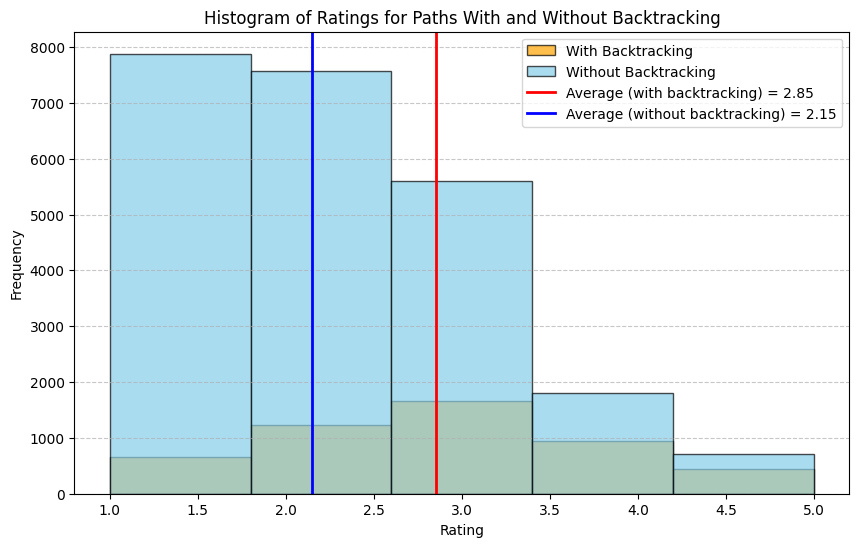

In [7]:
# Collect ratings for paths with and without backtracking
filtered_ratings_back = []
filtered_ratings = []

for index, row in paths_finished.iterrows():
    if '<' in row['path'].split(';') and pd.notna(row['rating']):
        filtered_ratings_back.append(row['rating'])  # Paths with backtracking
    elif '<' not in row['path'].split(';') and pd.notna(row['rating']):
        filtered_ratings.append(row['rating'])  # Paths without backtracking

# Calculate the average for each group
average_back = sum(filtered_ratings_back) / len(filtered_ratings_back) if filtered_ratings_back else 0
average_no_back = sum(filtered_ratings) / len(filtered_ratings) if filtered_ratings else 0

print("Average rating (with backtracking):", average_back)
print("Average rating (without backtracking):", average_no_back)

# Plot the histograms
plt.figure(figsize=(10, 6))

# Plot histogram for paths with backtracking
plt.hist(filtered_ratings_back, bins=5, color='orange', edgecolor='black', alpha=0.7, label='With Backtracking')

# Plot histogram for paths without backtracking
plt.hist(filtered_ratings, bins=5, color='skyblue', edgecolor='black', alpha=0.7, label='Without Backtracking')

# Add vertical lines for the averages
plt.axvline(x=average_back, color='red', linestyle='-', linewidth=2, label=f'Average (with backtracking) = {average_back:.2f}')
plt.axvline(x=average_no_back, color='blue', linestyle='-', linewidth=2, label=f'Average (without backtracking) = {average_no_back:.2f}')

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings for Paths With and Without Backtracking')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [8]:
print(f"Across the study, we have {len(paths_finished)} paths, while {len(paths_unfinished)} remain unfinished, for a total of {len(clean_merge)} paths.")

Across the study, we have 51317 paths, while 24874 remain unfinished, for a total of 76191 paths.


In [9]:
# Calculate the average number of backtracks for finished vs unfinished paths
avg_backtracks_finished = clean_merge[clean_merge['status'] == 'finished']['backtracks'].apply(len).mean()
avg_backtracks_unfinished = clean_merge[clean_merge['status'] != 'finished']['backtracks'].apply(len).mean()

# Output the results
print("\nAverage number of backtracks per game:")
print(f"Finished paths: {avg_backtracks_finished:.2f}")
print(f"Unfinished paths: {avg_backtracks_unfinished:.2f}")



Average number of backtracks per game:
Finished paths: 0.40
Unfinished paths: 0.52


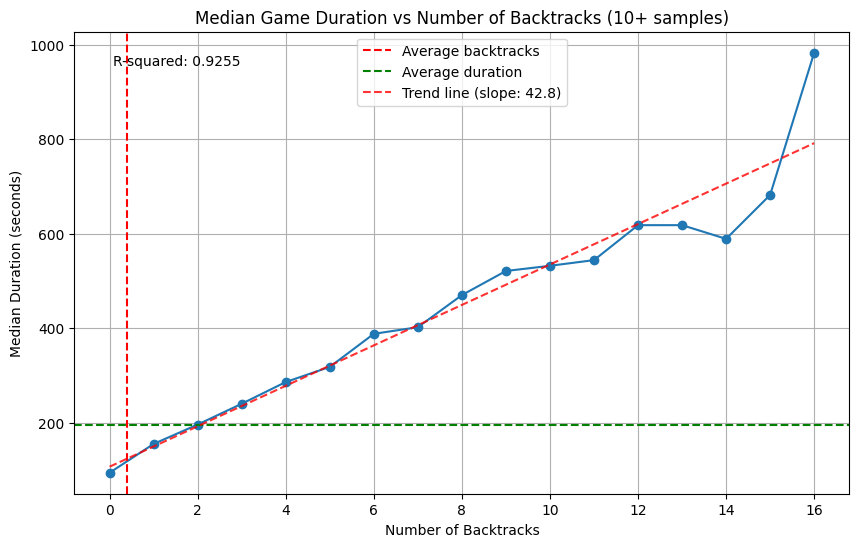

Counts of games with each number of backtracks:
backtracks
0     42322
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
dtype: int64

R-squared value: 0.9255


In [10]:
# Get finished games with and without backtracks

finished_with_bt = paths_finished[paths_finished['backtracks'].apply(len) > 0]
finished_no_bt = paths_finished[paths_finished['backtracks'].apply(len) == 0]

# Calculate average duration for each group
avg_duration_with_bt = finished_with_bt['durationInSec'].median()
avg_duration_no_bt = finished_no_bt['durationInSec'].median()

# Group finished games by number of backtracks and calculate median duration
backtrack_counts = paths_finished.groupby(paths_finished['backtracks'].apply(len)).size()
backtrack_durations = paths_finished.groupby(paths_finished['backtracks'].apply(len))['durationInSec'].median()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_durations = backtrack_durations[filtered_counts.index]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(filtered_durations.index, filtered_durations.values, marker='o')
plt.axvline(x=avg_backtracks_finished, color='r', linestyle='--', label='Average backtracks')
plt.axhline(y=avg_duration_with_bt, color='g', linestyle='--', label='Average duration')
plt.xlabel('Number of Backtracks')
plt.ylabel('Median Duration (seconds)')
plt.title('Median Game Duration vs Number of Backtracks (10+ samples)')
plt.grid(True)

# Add a trend line
z = np.polyfit(filtered_durations.index, filtered_durations.values, 1)
p = np.poly1d(z)
plt.plot(filtered_durations.index, p(filtered_durations.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

# Calculate R-squared
r_squared = r2_score(filtered_durations.values, p(filtered_durations.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

print("Counts of games with each number of backtracks:")
print(filtered_counts)
print(f"\nR-squared value: {r_squared:.4f}")



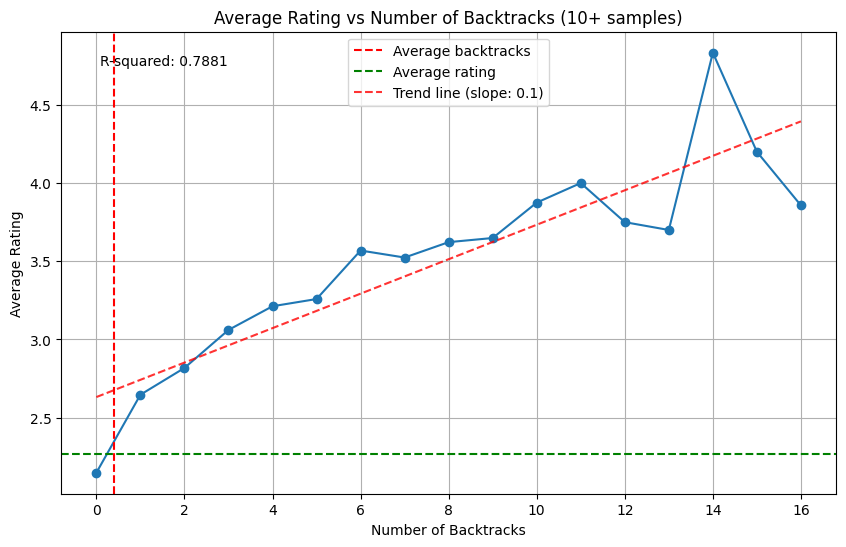

Counts of games with each number of backtracks:
backtracks
0     42322
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
dtype: int64

R-squared value: 0.7881


In [11]:
# Group finished games by number of backtracks and calculate median duration
backtrack_counts = paths_finished.groupby(paths_finished['backtracks'].apply(len)).size()
backtrack_ratings = paths_finished.groupby(paths_finished['backtracks'].apply(len))['rating'].mean()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_ratings = backtrack_ratings[filtered_counts.index]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(filtered_ratings.index, filtered_ratings.values, marker='o')
plt.xlabel('Number of Backtracks')
plt.ylabel('Average Rating')
plt.axvline(x=avg_backtracks_finished, color='r', linestyle='--', label='Average backtracks')
plt.axhline(y=paths_finished['rating'].mean(), color='g', linestyle='--', label='Average rating')
plt.title('Average Rating vs Number of Backtracks (10+ samples)')
plt.grid(True)

# Add a trend line
z = np.polyfit(filtered_ratings.index, filtered_ratings.values, 1)
p = np.poly1d(z)

plt.plot(filtered_ratings.index, p(filtered_ratings.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

# Calculate R-squared
r_squared = r2_score(filtered_ratings.values, p(filtered_ratings.index))

plt.legend()
plt.text(0.05, 0.95, f'R-squared: {r_squared:.4f}', transform=plt.gca().transAxes, 
         verticalalignment='top')
plt.show()

print("Counts of games with each number of backtracks:")
print(filtered_counts)
print(f"\nR-squared value: {r_squared:.4f}")

                                                    backtracks  traversed  \
Local community                                            2.0          3   
Soil profile                                              29.0         47   
Wikipedia Text of the GNU Free Documentation Li...        61.0        122   
La Grande Armée                                            2.0          4   
Skåneland                                                  1.0          2   
Póvoa de Varzim                                            1.0          2   
Konrad Lorenz                                              4.0          9   
Shackleton (crater)                                        5.0         12   
Cape Canaveral                                            26.0         63   
Lighting designer                                         17.0         44   
Lens (anatomy)                                            23.0         60   
Income disparity                                           4.0         11   

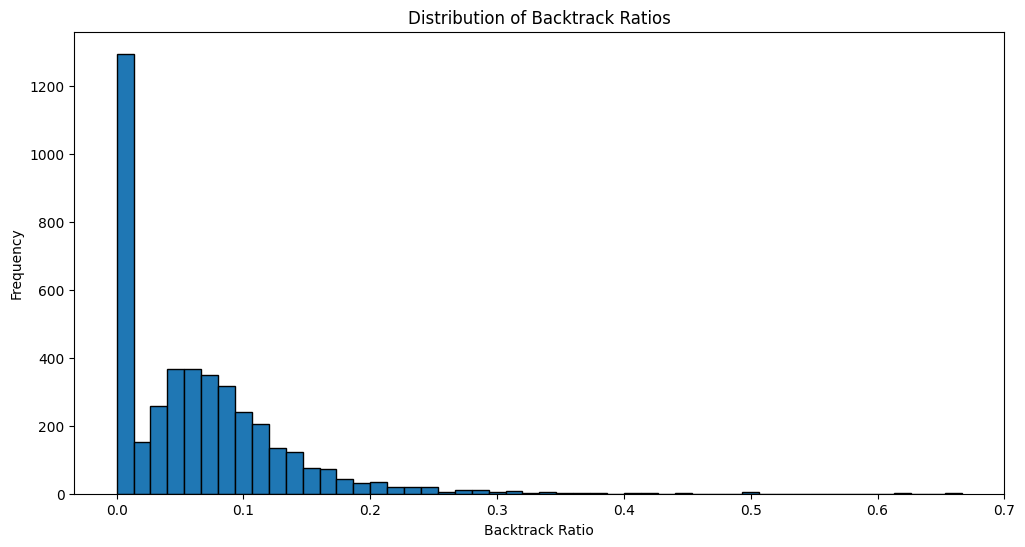

In [12]:

# Create a DataFrame with counts of backtracks and traversed
backtracks = pd.Series(clean_merge['backtracks'].explode().dropna().tolist())
def path_to_list(path):
    return [urllib.parse.unquote(word).replace('_', ' ') for word in path.replace('<;', '').split(';')]

clean_merge["traversed"] = clean_merge["path"].apply(path_to_list)
traversed = pd.Series(clean_merge['traversed'].explode().dropna().tolist())

word_counts = pd.DataFrame({
    'backtracks': backtracks.value_counts(),
    'traversed': traversed.value_counts()
})

# Calculate the ratio of backtracks to traversed
word_counts['backtrack_ratio'] = word_counts['backtracks'] / word_counts['traversed']

# Fill NaN values with 0 (for words that were traversed but never backtracked)
word_counts['backtrack_ratio'] = word_counts['backtrack_ratio'].fillna(0)

# Sort by the ratio in descending order
word_counts_sorted = word_counts.sort_values('backtrack_ratio', ascending=False)

# Display the top 20 words with highest backtrack ratios for words with at least 100 occurrences
print(word_counts_sorted[word_counts_sorted['traversed'] >= 0].head(20))

# Optional: Plot the distribution of backtrack ratios
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(word_counts['backtrack_ratio'], bins=50, edgecolor='black')
plt.title('Distribution of Backtrack Ratios')
plt.xlabel('Backtrack Ratio')
plt.ylabel('Frequency')
plt.show()



In [13]:
paths_unfinished.groupby('type').count()

,hashedIpAddress,timestamp,durationInSec,path,target,status,backtracks
type,,,,,,,
restart,15552,15552,15552,15552,15552,15552,15552
timeout,9322,9322,9322,9322,9322,9322,9322


In [14]:
# Count the number of games in each 'type' group
game_counts_by_type = paths_unfinished.groupby('type').size()

# Display the result
print(game_counts_by_type)


type
restart    15552
timeout     9322
dtype: int64


# Explanation

In [15]:
# Get all backtrack targets
backtrack_targets = clean_merge[clean_merge['backtracks'].apply(len) > 0][['backtracks','target']]
print(backtrack_targets.head())
# Create a list to store individual backtrack entries
backtrack_entries = []

# Iterate through each row that has backtracks
for _, row in backtrack_targets.iterrows():
    # For each backtrack in the row
    for backtrack in row['backtracks']:
        # Add an entry with the backtrack and target
        backtrack_entries.append({
            'backtrack': backtrack,
            'target': row['target']
        })

# Convert to DataFrame
backtrack_df = pd.DataFrame(backtrack_entries)

print("\nArticle of backtrack vs target")
print(backtrack_df.value_counts().head(20))


                                           backtracks target
9                                          [Sunlight]    NaN
12     [Sunlight, Rain, Earth's atmosphere, Sunlight]    NaN
13                                      [Cloud, Rain]    NaN
15  [Republic of Ireland, Europe, Europe, Republic...    NaN
18         [Physics, Ultraviolet, Earth's atmosphere]    NaN

Article of backtrack vs target
backtrack         target       
Soybean           Bean             54
Sport             Tiger Woods      42
Herbivore         Zebra            33
Salsa music       Bean             27
Protein           Bean             26
Cell (biology)    Telephone        21
Mexico            Bean             20
Agriculture       Bean             20
Olympic Games     Tiger Woods      20
Computer science  Telephone        19
Soil profile      Soil moisture    18
Zebra shark       Nurse sharks     17
Coffee            Bean             16
Plant             Bean             15
Internet          Telephone        15


In [16]:
# Find missing targets more efficiently and store them in a list
missing_targets = [target for target in paths_unfinished['target'] if target not in set(articles['article'])]

# Print missing targets if any
if missing_targets:
    print("Missing targets:")
    for target in missing_targets:
        print(target)
else:
    print("No missing targets found.")


Missing targets:
Long peper
Test
Adolph Hitler
Netbook
Podcast
Christmas
Sportacus
Charlottes web
Macedonia
Usa
 Zebra
Rss
Black ops 2
Western Australia
The Rock
Great
Georgia
English
Fats
Mustard
Christmas
Christmas
Bogota
The
Rat
Kashmir
Christmas
Christmas


# Solution

In [17]:
all_path_similarities = pd.read_csv('data/similarities.csv')
all_path_similarities['last_article'] = all_path_similarities['path'].apply(lambda x: eval(x)[0][-1])
all_path_similarities_unfinished = all_path_similarities[all_path_similarities['last_article'] != all_path_similarities['target']]
all_path_similarities_finished = all_path_similarities[all_path_similarities['last_article'] == all_path_similarities['target']]
all_path_similarities_finished.head()

,OpenAI,target,path,last_article
0,"[[0.27250955391064935, 0.2070933106970122, 0.3...",African slave trade,"[['14th century', 'Europe', 'Africa', 'Atlanti...",African slave trade
1,"[[0.27250955391064935, 0.214902261382967, 0.22...",African slave trade,"[['14th century', 'Niger', 'Nigeria', 'British...",African slave trade
2,"[[0.16587847219917598, 0.2303523759254455, 0.6...",Greece,"[['14th century', 'Renaissance', 'Ancient Gree...",Greece
3,"[[0.08519395595681435, 0.09169799390481226, 0....",John F. Kennedy,"[['14th century', 'Italy', 'Roman Catholic Chu...",John F. Kennedy
4,"[[0.08519395595681435, 0.10066178434998091, 0....",John F. Kennedy,"[['14th century', 'Europe', 'North America', '...",John F. Kennedy


In [18]:
# Take only the last 10 elements of each path
def shorten_list(x,n=10):
    x = eval(x.replace(" ", ""))  # Convert string representation of list to actual list
    x=x[0] #unpack the list
    if len(x) > n:
        return x[-n:]
    return x

def handle_unfinished(x,n=9):
    x = eval(x.replace(" ", ""))  # Convert string representation of list to actual list
    x = x[0] #unpack the list
    max_value = max(x)
    if max_value < 0.3:
        return []
    max_index = x.index(max_value)
    x = x[:max_index + 1]  # Keep only values up to and including max
    if len(x) > n:
        return x[-n:]
    return x

all_path_similarities_unfinished_copy = all_path_similarities_unfinished.copy()
all_path_similarities_unfinished_copy['OpenAI'] = all_path_similarities_unfinished_copy['OpenAI'].apply(handle_unfinished)
similarities_unfinished = all_path_similarities_unfinished_copy['OpenAI'][all_path_similarities_unfinished_copy['OpenAI'].apply(lambda x: len(x) > 0)]

all_path_similarities_finished_copy = all_path_similarities_finished.copy()
all_path_similarities_finished_copy['OpenAI'] = all_path_similarities_finished_copy['OpenAI'].apply(shorten_list)
similarities_finished = all_path_similarities_finished_copy['OpenAI']

ValueError: '[' is not a valid format string (unrecognized character '[')

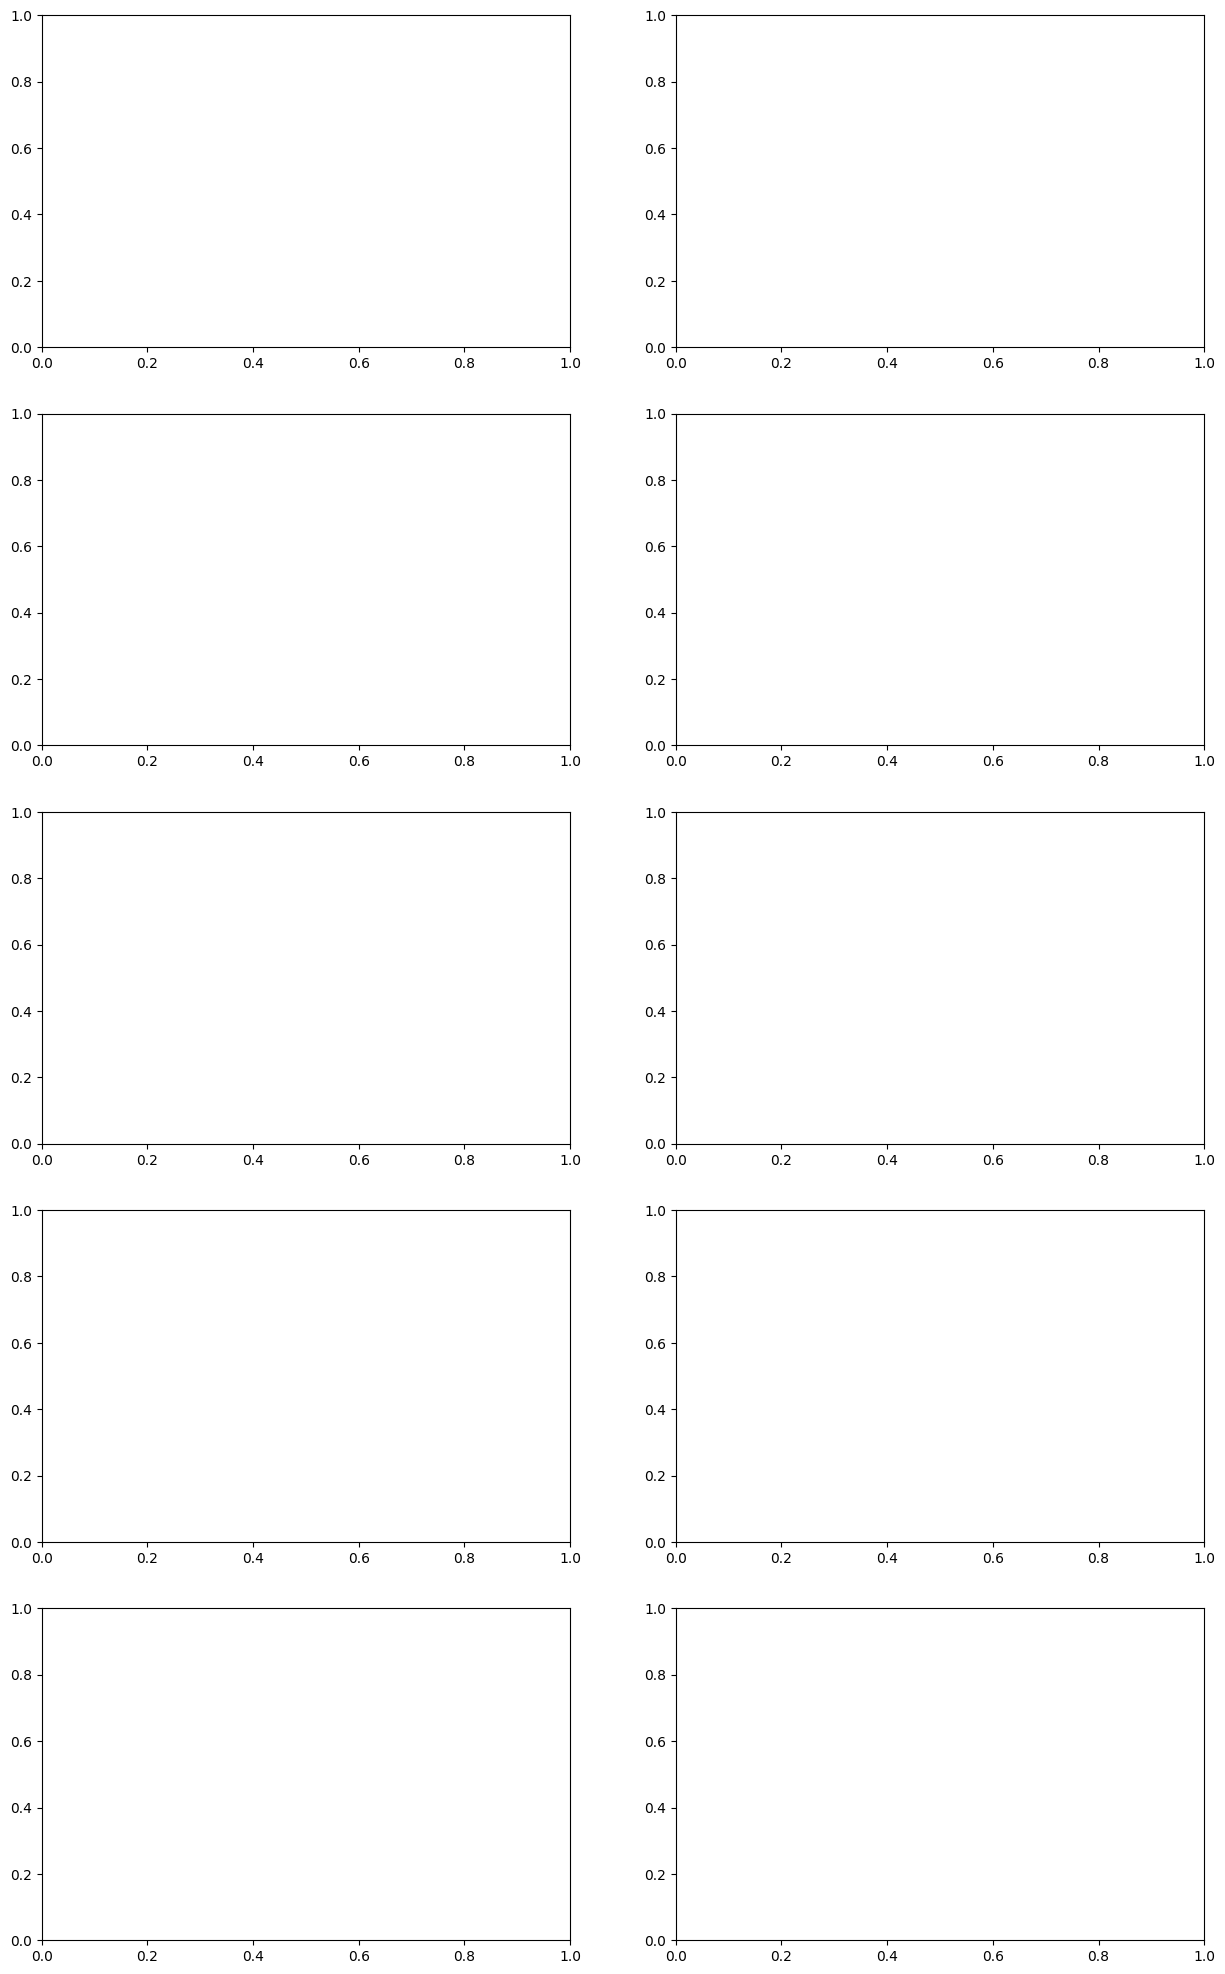

In [19]:
final_results = all_path_similarities
# Create a figure with subplots for the first 10 paths
fig, axes = plt.subplots(5, 2, figsize=(15, 25))
axes = axes.flatten()

# Colors for each model
colors = {
    #'SentenceBERT': 'blue',
    #'CLIP': 'red', 
    'OpenAI': 'green'
}

# Plot first 10 paths
for i in range(10):
    path = final_results['path'].iloc[i][0]
    target = final_results['target'].iloc[i]
    
    # Plot each model's similarities
    for model in ['OpenAI']:
        similarities = final_results[model].iloc[i][0]
        axes[i].plot(range(len(similarities)), similarities, 
                    marker='o', label=model, color=colors[model])
    
    # Customize the plot
    axes[i].set_title(f'Path {i+1}\nTarget: {target}')
    axes[i].set_xlabel('Step in Path')
    axes[i].set_ylabel('Cosine Similarity')
    axes[i].set_ylim(0, 1)
    axes[i].grid(True)
    axes[i].legend()
    
    # Add path words as x-tick labels
    axes[i].set_xticks(range(len(path)))
    axes[i].set_xticklabels(path, rotation=45, ha='right')

plt.tight_layout()
plt.show()


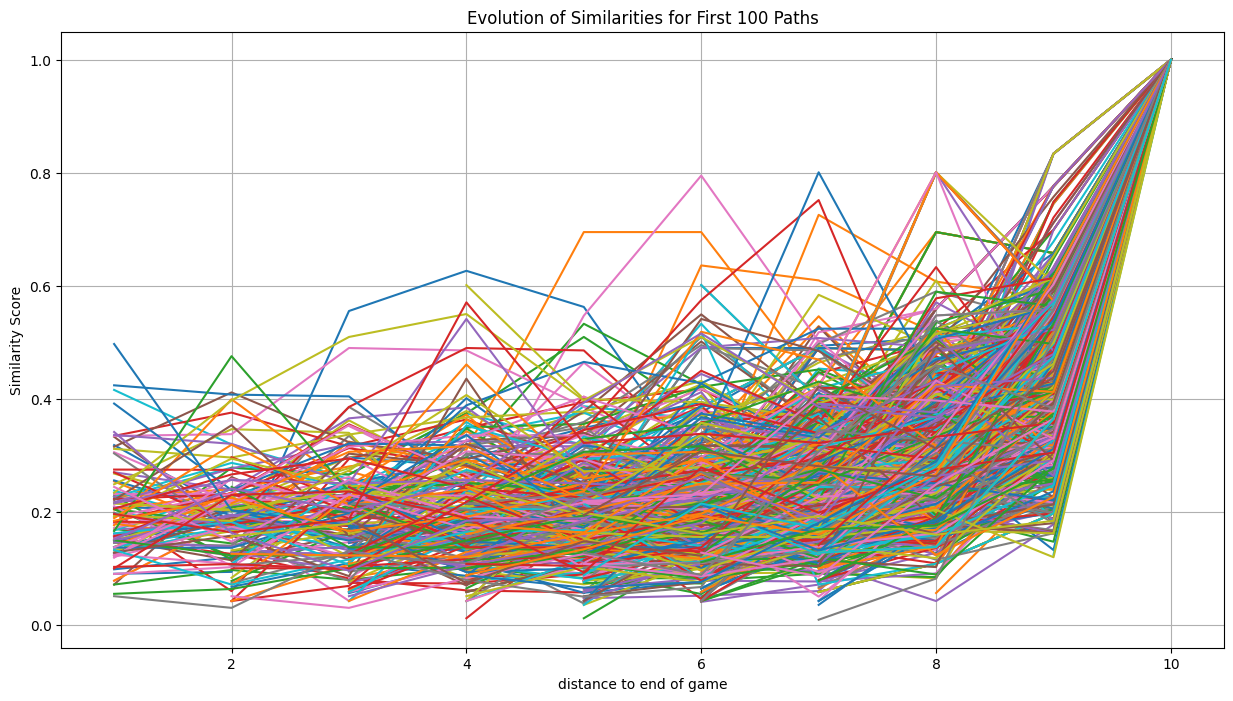

In [20]:
# Create figure and axis
plt.figure(figsize=(15, 8))
n=10

# Plot first 100 similarity evolutions
for i in range(1000):
    similarities = all_path_similarities_finished_copy['OpenAI'].iloc[i]
    reversed_similarities = similarities[::-1]
    indexes = range(n,n-len(reversed_similarities),-1)
    plt.plot(indexes, reversed_similarities)


plt.xlabel('distance to end of game')
plt.ylabel('Similarity Score') 
plt.title('Evolution of Similarities for First 100 Paths')

# Add grid for better readability
plt.grid(True)

plt.show()


In [21]:
distance_to_series_finished ={}
for i in tqdm(range(len(similarities_finished))):
    similarities = similarities_finished.iloc[i]
    reversed_similarities = similarities[::-1]
    for j in range(len(reversed_similarities)):
        distance_to_series_finished[j] = distance_to_series_finished.get(j,[]) + [reversed_similarities[j]]

print(len(distance_to_series_finished))

distance_to_series_unfinished ={}
for i in tqdm(range(len(similarities_unfinished))):
    similarities = similarities_unfinished.iloc[i]
    reversed_similarities = similarities[::-1]
    for j in range(len(reversed_similarities)):
        distance_to_series_unfinished[j] = distance_to_series_unfinished.get(j,[]) + [reversed_similarities[j]]

print(distance_to_series_unfinished)


l_finished=[]
for i in range(len(distance_to_series_finished)):
    l_finished.append(distance_to_series_finished[i])

l_unfinished=[]
for i in range(len(distance_to_series_unfinished)):
    l_unfinished.append(distance_to_series_unfinished[i])

100%|██████████| 51318/51318 [00:15<00:00, 3373.37it/s] 


10


100%|██████████| 9641/9641 [00:00<00:00, 23131.22it/s]

{0: [0.43957460094280554, 0.5909848752213069, 0.4739430221231442, 0.3831635996765537, 0.38060468501842726, 0.530422145783612, 0.30464509024045566, 0.3781373771993638, 0.3371723138052344, 0.31979338034096555, 0.4358123196013387, 0.4048372176795637, 0.4895469301976203, 0.3096010312980664, 0.5220134641040103, 0.44471689945521464, 0.414964643242157, 0.43902032833756016, 0.3277967531690501, 0.420861136157171, 0.493288219208584, 0.49523929607854805, 0.5510885854500516, 0.5240130579660438, 0.6147852287458376, 0.33988506761621934, 0.5165163124138697, 0.30470998936811633, 0.32974967776472197, 0.4174932240026205, 0.39700363510632275, 0.5515611651452024, 0.40894481786837145, 0.4119826906334386, 0.3076700511613252, 0.32393368803896094, 0.3126250388569869, 0.5174034114169418, 0.30179274264357997, 0.4165138996658368, 0.5161464498329903, 0.30552835865178807, 0.3390386121358025, 0.5597353336241507, 0.5581259588228857, 0.41679302680270064, 0.5425726563580335, 0.505468128357427, 0.7609963885702924, 0.60

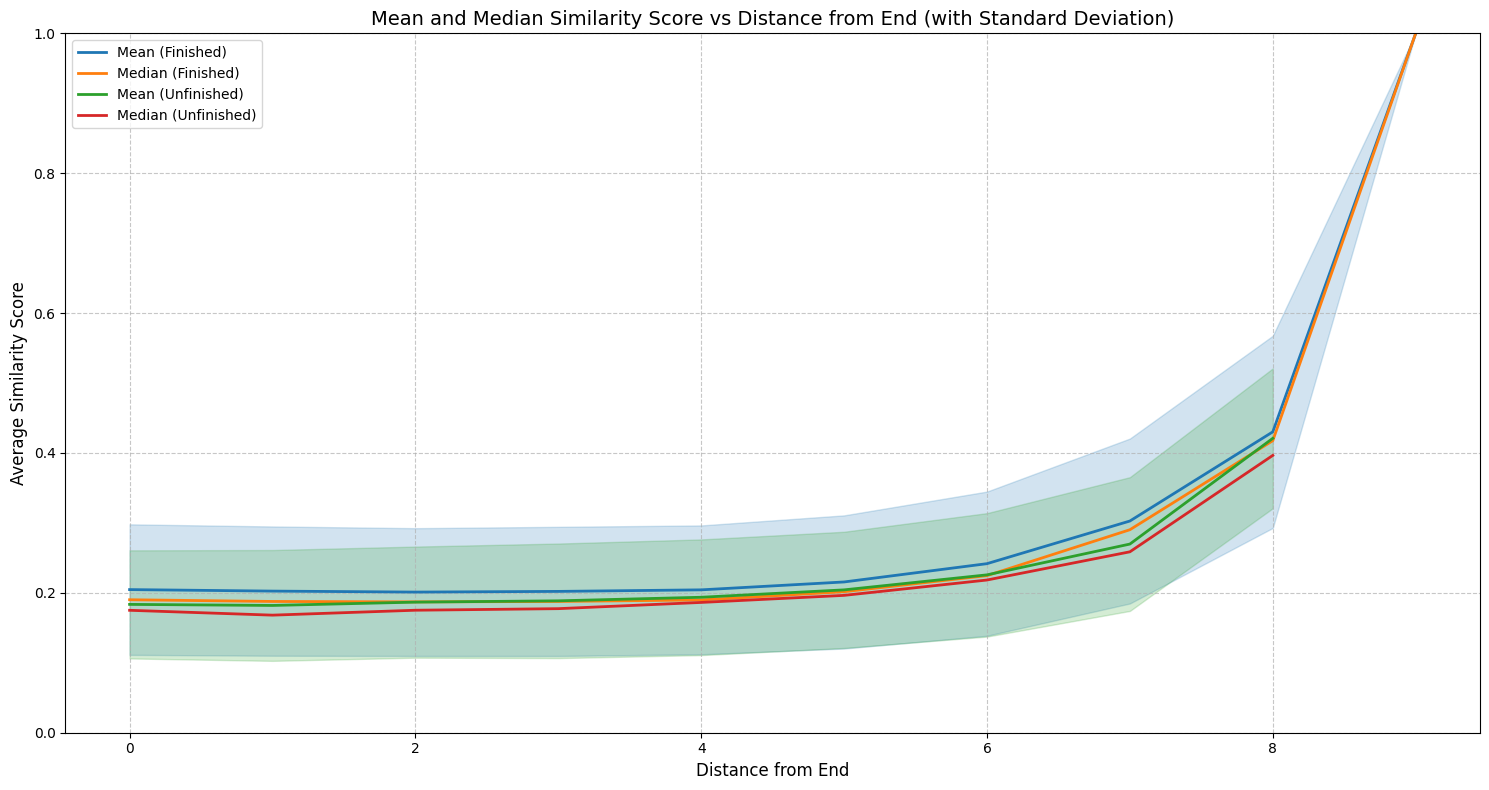

In [22]:



# Calculate means and standard deviations
means_finished = [np.mean(sublist) for sublist in l_finished]
medians_finished = [np.median(sublist) for sublist in l_finished]
stds_finished = [np.std(sublist) for sublist in l_finished]

means_unfinished = [np.mean(sublist) for sublist in l_unfinished]
medians_unfinished = [np.median(sublist) for sublist in l_unfinished]
stds_unfinished = [np.std(sublist) for sublist in l_unfinished]


# Create x-axis values (distances)
x_finished = range(len(means_finished)-1, -1, -1)  # Reversed range
x_unfinished = range(len(means_unfinished)-1, -1, -1)  # Reversed range

# Create figure and axis
plt.figure(figsize=(15, 8))

# Plot means with standard deviation areas
plt.plot(x_finished, means_finished, color='#1f77b4', label='Mean (Finished)', linewidth=2)
plt.plot(x_finished, medians_finished, color='#ff7f0e', label='Median (Finished)', linewidth=2)
plt.fill_between(x_finished, 
                 [m - s for m,s in zip(means_finished, stds_finished)],
                 [m + s for m,s in zip(means_finished, stds_finished)],
                 color='#1f77b4', alpha=0.2)

plt.plot(x_unfinished, means_unfinished, color='#2ca02c', label='Mean (Unfinished)', linewidth=2)
plt.plot(x_unfinished, medians_unfinished, color='#d62728', label='Median (Unfinished)', linewidth=2)
plt.fill_between(x_unfinished, 
                 [m - s for m,s in zip(means_unfinished, stds_unfinished)],
                 [m + s for m,s in zip(means_unfinished, stds_unfinished)],
                 color='#2ca02c', alpha=0.2)

plt.xlabel('Distance from End', fontsize=12)
plt.ylabel('Average Similarity Score', fontsize=12)
plt.ylim(0,1)

plt.title('Mean and Median Similarity Score vs Distance from End (with Standard Deviation)', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=10)


plt.tight_layout()
plt.show()


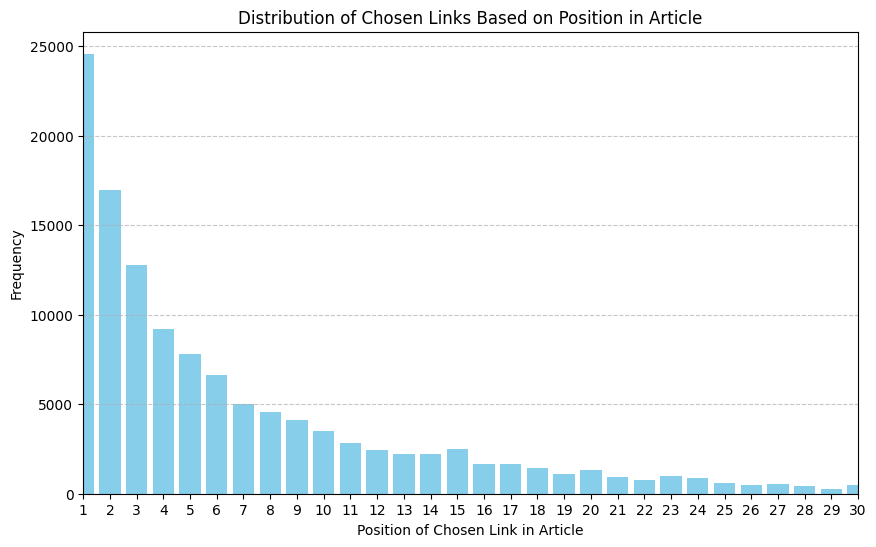

In [23]:
chosen_links_df =pd.read_csv('data/chosen_links_rank.csv')


rank_data = chosen_links_df['RankChosen'].dropna()

# Count the frequency of each rank
rank_counts = rank_data.value_counts()

plt.figure(figsize=(10, 6))
plt.bar(rank_counts.index, rank_counts.values, color='skyblue')
plt.xlabel('Position of Chosen Link in Article')
plt.xlim(1, 30)  # Limit to first 20 positions
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Links Based on Position in Article')

# Set x-ticks to show every position within the limited range
plt.xticks(range(1, 31))  # Adjust as necessary

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [24]:
# Step 1: Replace -1 values with np.nan to ignore them during normalization
distance_matrix_normalized = np.where(distance_matrix == -1, np.nan, distance_matrix)

# Step 2: Perform normalization on the matrix, excluding NaN values
min_value = np.nanmin(distance_matrix_normalized)
max_value = np.nanmax(distance_matrix_normalized)
distance_matrix_normalized = (distance_matrix_normalized - min_value) / (max_value - min_value)

# Step 3: Replace NaNs (original -1 values) with 1
distance_matrix_normalized = np.where(np.isnan(distance_matrix_normalized), 1, distance_matrix_normalized)


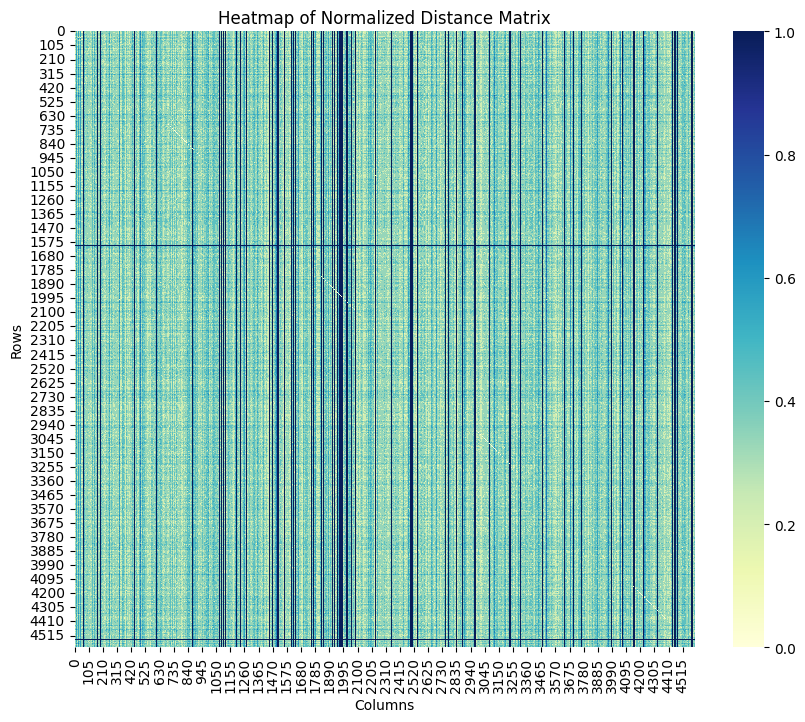

In [25]:
min_value = np.nanmin(distance_matrix_normalized)
max_value = np.nanmax(distance_matrix_normalized)
distance_matrix_normalized = (distance_matrix_normalized - min_value) / (max_value - min_value)

# Step 3: Replace NaNs (original -1 values) with 1
distance_matrix_normalized = np.where(np.isnan(distance_matrix_normalized), 1, distance_matrix_normalized)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix_normalized, cmap="YlGnBu", annot=False, cbar=True)
plt.title('Heatmap of Normalized Distance Matrix')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()
